In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
data = pd.read_csv('Mall_Customers.csv')
data.columns = ['cust_id', 'gender', 'age', 'income', 'spend_score']
data.head(), data.shape

(   cust_id  gender  age  income  spend_score
 0        1    Male   19      15           39
 1        2    Male   21      15           81
 2        3  Female   20      16            6
 3        4  Female   23      16           77
 4        5  Female   31      17           40, (200, 5))

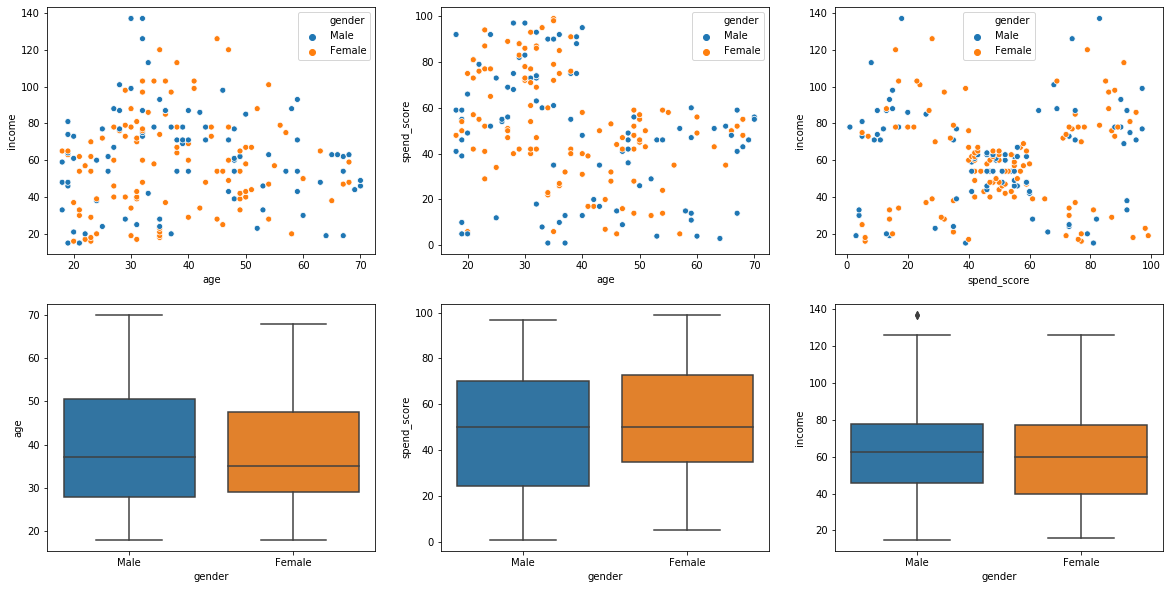

In [3]:
fig, ax = plt.subplots(2, 3, figsize=(20,10))
sns.scatterplot(x='age', y='income', hue='gender', data=data, ax=ax[0,0]);
sns.scatterplot(x='age', y='spend_score', hue='gender', data=data, ax=ax[0,1]);
sns.scatterplot(x='spend_score', y='income', hue='gender', data=data, ax=ax[0,2]);
sns.boxplot(x='gender', y='age', data=data, ax=ax[1,0]);
sns.boxplot(x='gender', y='spend_score', data=data, ax=ax[1,1]);
sns.boxplot(x='gender', y='income', data=data, ax=ax[1,2]);

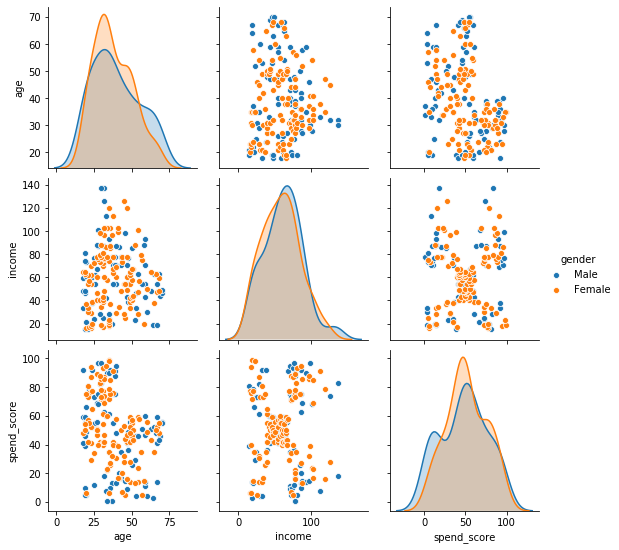

In [4]:
sns.pairplot(data[['age','income','spend_score','gender']], hue='gender');

In [5]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
gender_coding = encoder.fit_transform(data[['gender']])
encoder.categories_

[array(['Female', 'Male'], dtype=object)]

In [6]:
gender = pd.DataFrame(gender_coding, columns = ['Female','Male'])

In [7]:
numerical = data.loc[:,'age':]

In [8]:
data_preprocess = pd.concat([numerical,gender], axis=1)
data_preprocess.head()

,age,income,spend_score,Female,Male
0,19,15,39,0.0,1.0
1,21,15,81,0.0,1.0
2,20,16,6,1.0,0.0
3,23,16,77,1.0,0.0
4,31,17,40,1.0,0.0


In [9]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# scaler = MinMaxScaler()
scaler = StandardScaler()
processed_data = pd.DataFrame(scaler.fit_transform(data_preprocess.values), columns=data_preprocess.columns)
processed_data.head()

,age,income,spend_score,Female,Male
0,-1.424569,-1.738999,-0.434801,-1.128152,1.128152
1,-1.281035,-1.738999,1.195704,-1.128152,1.128152
2,-1.352802,-1.700830,-1.715913,0.886405,-0.886405
3,-1.137502,-1.700830,1.040418,0.886405,-0.886405
4,-0.563369,-1.662660,-0.395980,0.886405,-0.886405


In [10]:
from sklearn.decomposition import PCA
import umap

In [11]:
pca_vec = PCA(n_components=2)
pca_result = pca_vec.fit_transform(processed_data.iloc[:,:3])
pca_vec.explained_variance_ratio_.cumsum().max()

0.7757454566976749

In [16]:
trans = umap.UMAP(n_neighbors=10, n_components=2, random_state=50, min_dist=0)
embedding = trans.fit_transform(processed_data)

/Users/avinash/.pyenv/versions/3.8.1/lib/python3.8/site-packages/umap/spectral.py:227: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  warn(


In [17]:
dred = pd.DataFrame(embedding, columns = ['2d-one', '2d-two'])
dred.head()

,2d-one,2d-two
0,8.501338,-0.631993
1,8.421077,-0.913840
2,-2.734550,0.988753
3,-4.206505,3.812429
4,-2.646816,0.805165


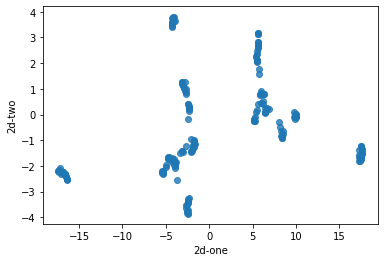

In [18]:
sns.regplot(x='2d-one', y='2d-two', data=dred, fit_reg=False);

In [19]:
import hdbscan

In [20]:
results = []
for min_samples in range(1,11):
    for min_cluster_size in range(10,100,10):
        for metric in ['euclidean', 'manhattan']:
            clusterer = hdbscan.HDBSCAN(algorithm='best', min_cluster_size=min_cluster_size, min_samples=min_samples, metric=metric, prediction_data=True).fit(dred)
            num_clusters = clusterer.labels_.max()
            n_clustered = len(np.where(clusterer.labels_>=0)[0])
            noise = n_clustered/np.shape(dred)[0]
            results.append((min_cluster_size, min_samples, metric, clusterer.labels_.max(), noise))
res = pd.DataFrame(results, columns = ['min_cluster_size', 'min_samples', 'metric', 'clusters', 'performance'])
res = res.sort_values(by=['performance'], ascending=False)
res.head()

,min_cluster_size,min_samples,metric,clusters,performance
0,10,1,euclidean,10,1.000
18,10,2,euclidean,10,1.000
37,10,3,manhattan,10,1.000
19,10,2,manhattan,10,1.000
55,10,4,manhattan,11,0.995


In [21]:
res.sort_values(by=['performance'], ascending=False).head()

,min_cluster_size,min_samples,metric,clusters,performance
0,10,1,euclidean,10,1.000
19,10,2,manhattan,10,1.000
18,10,2,euclidean,10,1.000
37,10,3,manhattan,10,1.000
55,10,4,manhattan,11,0.995


In [22]:
clusterer = hdbscan.HDBSCAN(algorithm='best', min_cluster_size=10, min_samples=2, metric='euclidean', prediction_data=True).fit(dred)
num_clusters = clusterer.labels_.max()
n_clustered = len(np.where(clusterer.labels_>=0)[0])
print('Classified by HDBSCAN: {:.2f}'.format(n_clustered/np.shape(dred)[0]))

Classified by HDBSCAN: 1.00


In [23]:
labels, strengths = hdbscan.approximate_predict(clusterer, dred)

In [24]:
data['cluster'] = labels
data.head()

,cust_id,gender,age,income,spend_score,cluster
0,1,Male,19,15,39,5
1,2,Male,21,15,81,5
2,3,Female,20,16,6,6
3,4,Female,23,16,77,2
4,5,Female,31,17,40,6


In [25]:
data.groupby(['cluster'])['cust_id'].count()

cluster
0     21
1     18
2     13
3     10
4     14
5     11
6     21
7     29
8     20
9     31
10    12
Name: cust_id, dtype: int64

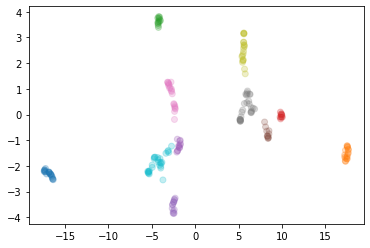

In [26]:
dred['cluster'] = labels
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
dred['color'] = '#9b59b6'
for i in range(0,10):
    dred.loc[dred.cluster == i,'color'] = colors[i]
plt.scatter(x='2d-one', y='2d-two', data=dred, c=dred['color'], alpha=0.25);

In [27]:
data_preprocess['cluster'] = labels
cluster_stats = data_preprocess.groupby('cluster')[['age','income','spend_score','Male','Female']].mean().reset_index()
cluster_stats

,cluster,age,income,spend_score,Male,Female
0,0,32.190476,86.047619,81.666667,0.0,1.0
1,1,33.277778,87.111111,82.666667,1.0,0.0
2,2,25.461538,25.692308,80.538462,0.0,1.0
3,3,21.600000,56.900000,52.600000,1.0,0.0
4,4,43.785714,93.285714,20.642857,0.0,1.0
5,5,25.181818,26.272727,72.545455,1.0,0.0
6,6,37.238095,33.285714,32.047619,0.0,1.0
7,7,55.896552,46.448276,40.551724,1.0,0.0
8,8,39.500000,85.150000,14.050000,1.0,0.0
9,9,51.483871,55.806452,48.225806,0.0,1.0


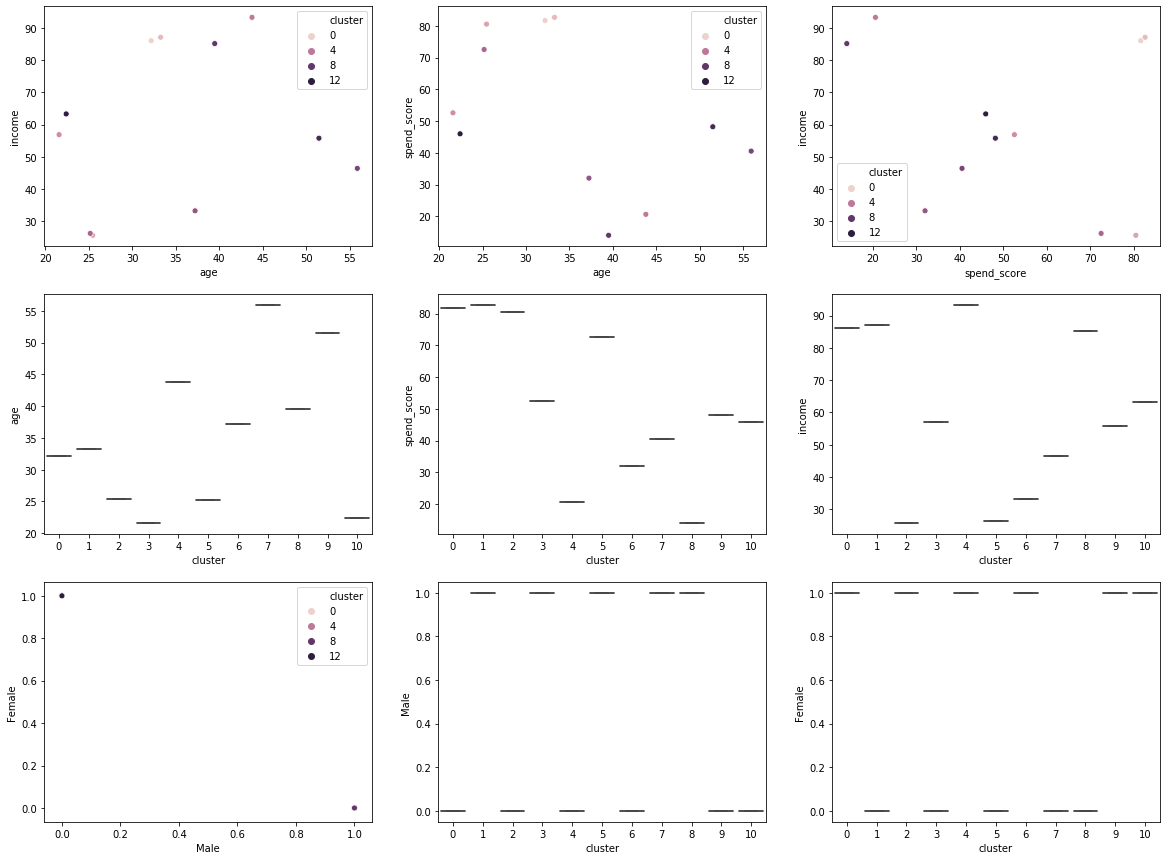

In [28]:
fig, ax = plt.subplots(3, 3, figsize=(20,15))
sns.scatterplot(x='age', y='income', hue='cluster', data=cluster_stats, ax=ax[0,0]);
sns.scatterplot(x='age', y='spend_score', hue='cluster', data=cluster_stats, ax=ax[0,1]);
sns.scatterplot(x='spend_score', y='income', hue='cluster', data=cluster_stats, ax=ax[0,2]);
sns.boxplot(x='cluster', y='age', data=cluster_stats, ax=ax[1,0]);
sns.boxplot(x='cluster', y='spend_score', data=cluster_stats, ax=ax[1,1]);
sns.boxplot(x='cluster', y='income', data=cluster_stats, ax=ax[1,2]);
sns.scatterplot(x='Male', y='Female', hue='cluster', data=cluster_stats, ax=ax[2,0]);
sns.boxplot(x='cluster', y='Male', data=cluster_stats, ax=ax[2,1]);
sns.boxplot(x='cluster', y='Female', data=cluster_stats, ax=ax[2,2]);

/Users/avinash/.pyenv/versions/3.8.1/lib/python3.8/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


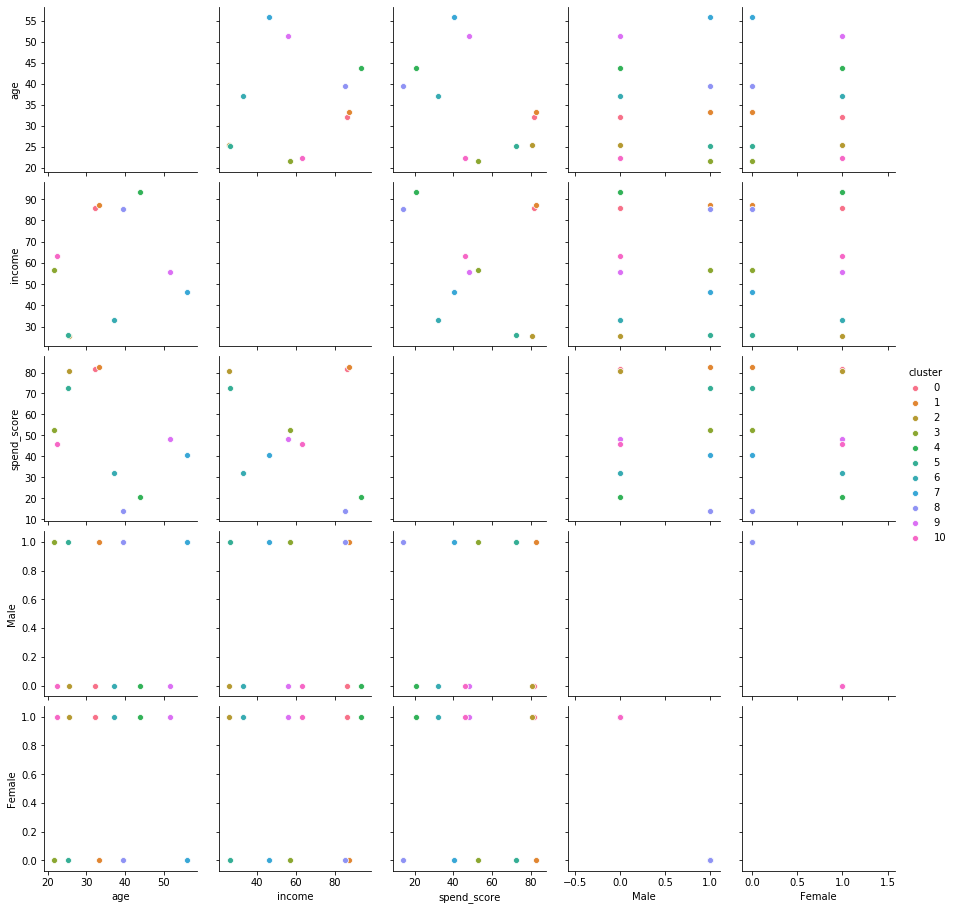

In [29]:
sns.pairplot(cluster_stats, hue='cluster');